# TODO

- 損失関数をアンサンブル
- 単純にCVスコアで重み付け

# Setting

In [1]:
import sys

import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

root_dir = "../../"
if root_dir not in sys.path:
    sys.path.append(root_dir)
from modules import config as cfg
from modules import utils, preprosess, training, predict, metrics

exp = "exp11"
utils.set_seed(cfg.Params.seed)

# Read data

In [2]:
train, test, submit = utils.get_data(debug_mode=False)

# Preprocessing

## Split fold

In [3]:
train = preprosess.assign_stratified_k_fold(train, "MIS_Status")

## Convert

In [4]:
# Cityを座標に変換
train = preprosess.convert_city_to_latlon(train)
test  = preprosess.convert_city_to_latlon(test)

# testのBankStateの"PR"はtrainにないため，一番多いCAに変換
test = test.with_columns(pl.col("BankState").str.replace("PR", "CA"))

# DisbursementDateとApprovalDateをYear(数値)に変換
cols  = ["DisbursementDate", "ApprovalDate"]
train = preprosess.convert_date_to_year(train, cols)
test  = preprosess.convert_date_to_year(test, cols)

# 金額データの数値化
cols  = ["DisbursementGross",  "GrAppv", "SBA_Appv"]
train = preprosess.convert_money_data(train, cols)
test  = preprosess.convert_money_data(test, cols)

# 一致しているか
eqs = [
    ["State", "BankState"],
]
train = preprosess.add_eq(train, eqs)
test  = preprosess.add_eq(test, eqs)

# 差の計算
diffs = [
    ["DisbursementGross", "GrAppv"],   # 支払われた額 vs 銀行承認額
    ["DisbursementGross", "SBA_Appv"], # 支払われた額 vs SBA承認額
    ["GrAppv", "SBA_Appv"],            # 銀行承認額 vs SBA承認額
]
train = preprosess.add_diff(train, diffs)
test  = preprosess.add_diff(test, diffs)

# DisbursementDateとApprovalDateの差を計算
train = preprosess.add_diff_disbursement_with_approval(train)
test  = preprosess.add_diff_disbursement_with_approval(test)

# 割合の計算
divs = [
    # ["DisbursementGross", "Term"],
    ["GrAppv", "Term"],
    ["SBA_Appv", "Term"],
    ["NoEmp", "Term"],
    # ["DisbursementGross", "NoEmp"],
    # ["GrAppv", "NoEmp"],
    # ["SBA_Appv", "NoEmp"],
    ["DisbursementGross_GrAppv_diff", "Term"],
    ["DisbursementGross_SBA_Appv_diff", "Term"],
    ["GrAppv_SBA_Appv_diff", "Term"],
    # ["DisbursementGross_GrAppv_diff", "NoEmp"],
    # ["DisbursementGross_SBA_Appv_diff", "NoEmp"],
    # ["GrAppv_SBA_Appv_diff", "NoEmp"]
]
train = preprosess.add_div(train, divs)
test  = preprosess.add_div(test, divs)

# Sectorを職業別にする
train = preprosess.unify_same_sector(train)
test  = preprosess.unify_same_sector(test)

## Target encoding

In [5]:
cols = [
    # "Sector",
    "UrbanRural",
    "RevLineCr",
    "LowDoc",
    "FranchiseCode",
]
target_col = "MIS_Status"
train, test = preprosess.target_encoding(train, test, cols)

## Label encoding
CVによるtarget encodingでは同じカテゴリカル変数に異なる値が割り当てられるのでlabel encodingを併用する

In [6]:
cols = ["RevLineCr", "LowDoc"]
train, test = preprosess.label_encoding(train, test, cols)

# Drop columns

In [7]:
# 不要なカラムの削除
del_cols = [
    # 地名系
    "City",
    "State",
    "BankState",
    # d-b-y系
    "DisbursementDate",
    "ApprovalDate",
    "ApprovalFY",
    # ラベルエンコーディング済み
    "RevLineCr",
    "LowDoc",
]
train = train.drop(del_cols)
test  = test.drop(del_cols)

# Training

In [8]:
results = []

In [9]:
# default
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'seed': cfg.Params.seed,
    'learning_rate': cfg.Params.learning_rate,
}
oof, models = training.fit_lgbm(train, lgb_params=lgb_params)
results.append((oof, models))

--------------------------------------------------------------------------------
START fold 1
[LightGBM] [Info] Number of positive: 30213, number of negative: 3632
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4971
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892687 -> initscore=2.118489
[LightGBM] [Info] Start training from score 2.118489
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.949211	valid_1's auc: 0.773659
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.949211	valid_1's auc: 0.773659
Time:  5.509[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 30213, number of negative: 3632
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892687 -> initscore=2.118489
[LightGBM] [Info] Start training from score 2.118489
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.94959	valid_1's auc: 0.777805
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.94959	valid_1's auc: 0.777805
Time:  3.164[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Info] Number of positive: 30214, number of negative: 3632
[LightGBM] [Warning] Auto-choosing col-wise 

In [10]:
# Focal loss
lgb_params = {
    'objective': 'binary',
    'metric': 'custom',
    'boosting_type': 'gbdt',
    'seed': cfg.Params.seed,
    'learning_rate': cfg.Params.learning_rate,
}
oof, models = training.fit_lgbm_fl(train, lgb_params=lgb_params, alpha=0.2, gamma=1.0)
results.append((oof, models))

--------------------------------------------------------------------------------
START fold 1
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4971
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.2_gamma1.0: 0.154552	valid_1's Focal_alpha0.2_gamma1.0: 0.723264
Did not meet early stopping. Best iteration is:
[65]	training's Focal_alpha0.2_gamma1.0: 0.0580832	valid_1's Focal_alpha0.2_gamma1.0: 0.489355
Time:  3.890[s]
--------------------------------------------------------------------------------
START fold 2
[LightGBM] [Warning] U

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.2_gamma1.0: 0.208628	valid_1's Focal_alpha0.2_gamma1.0: 0.817903
Did not meet early stopping. Best iteration is:
[57]	training's Focal_alpha0.2_gamma1.0: 0.0769153	valid_1's Focal_alpha0.2_gamma1.0: 0.537591
Time:  3.458[s]
--------------------------------------------------------------------------------
START fold 4
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4969
[LightGBM] [Info] Number of data points in the train set: 33846, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.2_gamma1.0: 0.984523	valid_1's Focal_alpha0.2_gamma1.0: 1.30742
Did not meet early sto

In [11]:
# Cross entropy loss
lgb_params = {
    'objective': 'binary',
    'metric': 'custom',
    'boosting_type': 'gbdt',
    'seed': cfg.Params.seed,
    'learning_rate': cfg.Params.learning_rate,
}
oof, models = training.fit_lgbm_wcel(train, lgb_params=lgb_params, alpha=0.2)
results.append((oof, models))

--------------------------------------------------------------------------------
START fold 1
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4971
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's WCE_alpha0.2: 0.0986272	valid_1's WCE_alpha0.2: 0.155726
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.2: 0.0986272	valid_1's WCE_alpha0.2: 0.155726
Time:  2.611[s]
--------------------------------------------------------------------------------
START fold 2
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the over

## アンサンブルの重みを計算

In [12]:
threshold = 0.5
oof_truth = train[cfg.Cols.target].to_numpy()
cv_scores = []
for result in results:
    oof = result[0]
    oof_hat = predict.predict_class(oof, threshold=threshold)
    cv_score = metrics.macro_f1_score(oof_truth, oof_hat)
    cv_scores.append(cv_score)

print(f"cv_scores: {cv_scores}")
ensemble_weights = [cv_score / sum(cv_scores) for cv_score in cv_scores]

cv_scores: [0.638269748302189, 0.5850112336565383, 0.6639523624985488]


# Predict

In [54]:
threshold = 0.6

In [55]:
pred_probs = []
for i, result in enumerate(results):
    models = result[1]
    if i == 0:
        # default
        pred_probs.append(predict.predict_probability(models, test))
    else:
        # Focal loss or Cross entropy loss
        pred_probs.append(predict.predict_probability_sigmoid(models, test))

pred_prob = sum([pred_prob * ensemble_weight for pred_prob, ensemble_weight in zip(pred_probs, ensemble_weights)])
pred_class = predict.predict_class(pred_prob, threshold=threshold)

## CV score

In [56]:
oof_truth = train[cfg.Cols.target].to_numpy()
oof_prob = sum([result[0] * ensemble_weight for result, ensemble_weight in zip(results, ensemble_weights)])
oof_hat = predict.predict_class(oof_prob, threshold=threshold)
cv_score = metrics.macro_f1_score(oof_truth, oof_hat)
print(cv_score)

0.6611126829582988


## Check result

### oofとtestの予測値分布を比較してバグを確認

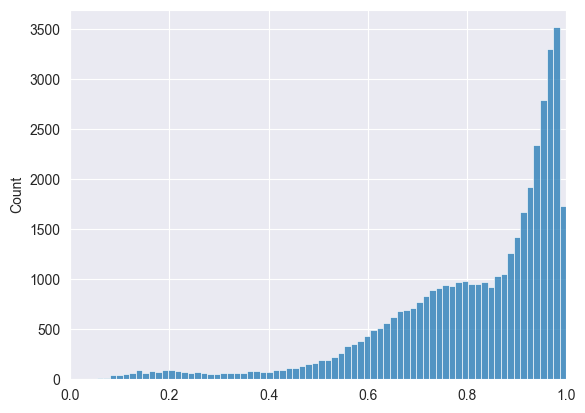

In [57]:
sns.histplot(oof_prob)
plt.xlim(0.0, 1.0)
plt.show()

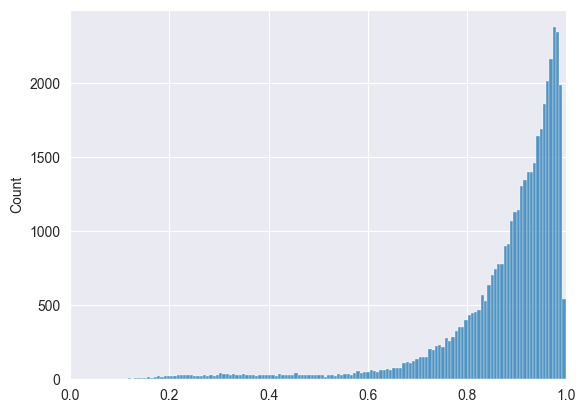

In [58]:
sns.histplot(pred_prob)
plt.xlim(0.0, 1.0)
plt.show()

### 予測値の1の割合を確認

In [59]:
print(pred_class.sum() / len(pred_class))

0.9519003498156378


### oofにおける混同行列を確認

True Negative Rate (0の正解率): 0.41
True Positive Rate (1の正解率): 0.92


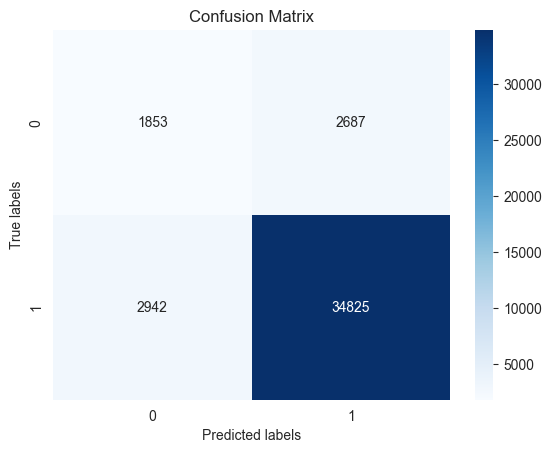

In [60]:
metrics.show_confusion_matrix(oof_truth, oof_hat)

## Submit

In [61]:
submit = submit.with_columns([pl.Series(cfg.Cols.sub_pred, pred_class)])
utils.make_submission(submit, exp, cv_score)